In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

def plot_aggregated_class_overlap(concept_path_files: list, 
                                config_to_use: str, 
                                l1_penalty_map: list, 
                                save_path_base: str = 'penalty_vs_overlap_dual_axis_aggregated'):
    """
    Loads concept path data from multiple runs for different SAE types, 
    aggregates the results, and plots metrics against the relevant x-axis 
    (L1 Penalty or Top-K Ratio).

    Generates a separate, dual-axis plot for each SAE type found (e.g., 'l1', 'topk').

    Args:
        concept_path_files (list): A list of file paths to the .pkl files 
                                   (e.g., ['run1.pkl', 'run2.pkl']).
        config_to_use (str): The extraction config to use (e.g., 'top_k_10').
        l1_penalty_map (list): The list of L1 penalty values to map indices to 
                               (required for L1 SAEs).
        save_path_base (str, optional): The base file name to save plots. 
                                        SAE type and extension will be added
                                        (e.g., 'my_plot' -> 'my_plot_l1.png').
    
    Returns:
        dict: A dictionary where keys are SAE types (e.g., 'l1', 'topk') and
              values are the aggregated DataFrames for that type.
    """
    
    # Set plot style
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    all_data_rows = []

    # ============================================================================
    # EXTRACT DATA FROM ALL RUNS
    # ============================================================================
    for run_idx, file_path in enumerate(concept_path_files):
        try:
            with open(file_path, 'rb') as f:
                all_concept_paths = pickle.load(f)
        except FileNotFoundError:
            warnings.warn(f"File not found: {file_path}. Skipping run {run_idx}.")
            continue
        except Exception as e:
            warnings.warn(f"Could not load {file_path}: {e}. Skipping run {run_idx}.")
            continue

        for sae_name, configs in all_concept_paths.items():
            if config_to_use not in configs:
                warnings.warn(f"Config '{config_to_use}' not found in {sae_name} "
                              f"for run {run_idx}, skipping SAE.")
                continue
            
            concept_data = configs[config_to_use]
            
            summary = concept_data.get('summary', {})
            overlap_analysis = concept_data.get('overlap_analysis', {})
            overlap_summary = overlap_analysis.get('summary', {})
            
            parts = sae_name.split('_')
            
            # --- Dynamic SAE Type Detection (FIXED) ---
            sae_type = None
            x_value = np.nan
            training_type = None
            dict_size = None

            try:
                # Check for most specific names first
                if sae_name.startswith('reanim_topk_sae'):
                    # e.g., reanim_topk_sae_256_140_best_loss
                    # parts: ['reanim', 'topk', 'sae', '256', '140', 'best', 'loss']
                    sae_type = 'topk'
                    training_type = 'reanim_topk'
                    dict_size = int(parts[3])
                    k_value = int(parts[4])
                    x_value = 1- (k_value / dict_size)  # Top-K Ratio

                elif sae_name.startswith('topk_sae'):
                    # e.g., topk_sae_512_230_best_loss
                    # parts: ['topk', 'sae', '512', '230', 'best', 'loss']
                    sae_type = 'topk'
                    training_type = 'topk'
                    dict_size = int(parts[2])
                    k_value = int(parts[3])
                    x_value = 1-(k_value / dict_size ) # Top-K Ratio

                elif sae_name.startswith('reanim_vanilla_sae'):
                    # e.g., reanim_vanilla_sae_256_10_best_loss
                    # parts: ['reanim', 'vanilla', 'sae', '256', '10', 'best', 'loss']
                    sae_type = 'l1'
                    training_type = 'reanim'
                    dict_size = int(parts[3])
                    penalty_index = int(parts[4])
                    if penalty_index >= len(l1_penalty_map):
                        warnings.warn(f"L1 penalty index {penalty_index} out of "
                                      f"range for {sae_name} in run {run_idx}")
                        continue
                    x_value = l1_penalty_map[penalty_index]
                
                elif sae_name.startswith('vanilla_sae'):
                    # e.g., vanilla_sae_256_10_best_loss
                    # parts: ['vanilla', 'sae', '256', '10', 'best', 'loss']
                    sae_type = 'l1'
                    training_type = 'vanilla'
                    dict_size = int(parts[2])
                    penalty_index = int(parts[3])
                    if penalty_index >= len(l1_penalty_map):
                        warnings.warn(f"L1 penalty index {penalty_index} out of "
                                      f"range for {sae_name} in run {run_idx}")
                        continue
                    x_value = l1_penalty_map[penalty_index]
                
                else:
                    warnings.warn(f"Unrecognized SAE name format: {sae_name}. Skipping.")
                    continue
            
            except (IndexError, ValueError, TypeError, ZeroDivisionError) as e:
                warnings.warn(f"Could not parse {sae_name} in run {run_idx}: {e}")
                continue
            # --- End Detection ---

            all_data_rows.append({
                'run_id': run_idx,
                'sae_name': sae_name,
                'sae_type': sae_type,
                'training_type': training_type,
                'dict_size': dict_size,
                'x_value': x_value,
                'mean_shared_neurons': overlap_summary.get('mean_shared_neurons', np.nan),
                'mean_jaccard': overlap_summary.get('mean_jaccard', np.nan),
                'unique_neurons': summary.get('total_unique_neurons_used', np.nan),
                'mean_active': summary.get('mean_active_neurons', np.nan)
            })

    if not all_data_rows:
        warnings.warn("No valid data extracted from any files. Aborting plot.")
        return {}

    # Create DataFrame and drop missing values
    df = pd.DataFrame(all_data_rows)
    df = df.dropna(subset=['x_value', 'mean_shared_neurons', 'mean_jaccard'])

    if df.empty:
        warnings.warn("Data was extracted but contained NaNs in critical columns. "
                      "Aborting plot.")
        return {}

    # ============================================================================
    # AGGREGATE AND PLOT PER SAE TYPE
    # ============================================================================
    
    all_agg_dfs = {}

    for sae_type, type_df in df.groupby('sae_type'):
        
        # Aggregate data for this SAE type
        agg_df = type_df.groupby(['training_type', 'dict_size', 'x_value']).agg(
            shared_neurons_mean=('mean_shared_neurons', 'mean'),
            shared_neurons_std=('mean_shared_neurons', 'std'),
            jaccard_mean=('mean_jaccard', 'mean'),
            jaccard_std=('mean_jaccard', 'std')
        ).reset_index()

        agg_df = agg_df.fillna({'shared_neurons_std': 0, 'jaccard_std': 0})
        all_agg_dfs[sae_type] = agg_df.sort_values(by='x_value') # Sort by x-axis

        # --- Setup Plot ---
        fig, ax1 = plt.subplots(figsize=(12, 7))
        ax2 = ax1.twinx() 

        palette = sns.color_palette("husl", len(agg_df.groupby(['training_type', 'dict_size'])))
        color_idx = 0
        lines_1, labels_1, lines_2, labels_2 = [], [], [], []

        for (training, dict_size), group in agg_df.groupby(['training_type', 'dict_size']):
            group = group.sort_values('x_value') # Ensure lines are drawn correctly
            color = palette[color_idx]
            
            # Capitalize training type for legend
            label_base = f"{training.replace('_', ' ').capitalize()} (dict={dict_size})"

            # --- Plot Mean Shared Neurons (ax1) ---
            line1, = ax1.plot(group['x_value'], 
                              group['shared_neurons_mean'],
                              marker='o', markersize=6, linewidth=2,
                              label=f"{label_base} - Shared Neurons",
                              alpha=0.8, color=color, linestyle='-')
            ax1.fill_between(group['x_value'],
                             group['shared_neurons_mean'] - group['shared_neurons_std'],
                             group['shared_neurons_mean'] + group['shared_neurons_std'],
                             color=color, alpha=0.15)
            lines_1.append(line1)
            labels_1.append(f"{label_base} - Shared Neurons")

            # --- Plot Mean Jaccard (ax2) ---
            line2, = ax2.plot(group['x_value'], 
                              group['jaccard_mean'],
                              marker='s', markersize=6, linewidth=2,
                              label=f"{label_base} - Jaccard",
                              alpha=0.8, color=color, linestyle='--')
            ax2.fill_between(group['x_value'],
                             group['jaccard_mean'] - group['jaccard_std'],
                             group['jaccard_mean'] + group['jaccard_std'],
                             color=color, alpha=0.15)
            lines_2.append(line2)
            labels_2.append(f"{label_base} - Jaccard")
            
            color_idx += 1

        # --- Dynamic Formatting ---
        if sae_type == 'l1':
            x_label = 'L1 Penalty (λ)'
            is_log_scale = True
        elif sae_type == 'topk':
            x_label = 'Top-K Ratio (k / dict_size)'
            is_log_scale = False # Top-K ratio is usually linear
        else:
            x_label = 'X Value'
            is_log_scale = False

        ax1.set_xlabel(x_label, fontsize=14, fontweight='bold')
        if is_log_scale:
            ax1.set_xscale('log')

        ax1.set_ylabel('Mean Shared Neurons', fontsize=14, fontweight='bold', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax2.set_ylabel('Mean Jaccard Similarity', fontsize=14, fontweight='bold', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        
        ax1.set_title(f'Aggregated Class Overlap vs. Sparsity ({sae_type.upper()})\n'
                      f'(N={len(concept_path_files)} Runs, Config: {config_to_use})', 
                      fontsize=16, fontweight='bold', pad=20)
        ax1.grid(True, alpha=0.3, which='both')
        fig.align_ylabels([ax1, ax2])

        # --- Combined Legend ---
        handles = lines_1 + lines_2
        labels = labels_1 + labels_2
        
        # Dynamically set number of columns in legend
        num_variants = len(agg_df.groupby(['training_type', 'dict_size']))
        legend_cols = max(1, min(num_variants, 3)) # Aim for 1-3 columns
        
        ax1.legend(handles, labels, 
                   loc='upper center', 
                   bbox_to_anchor=(0.5, -0.12), 
                   ncol=legend_cols,
                   fontsize=11, 
                   frameon=True,
                   columnspacing=1.5)

        fig.tight_layout()
        fig.subplots_adjust(bottom=0.25) # Adjust bottom margin for legend
        
        # --- Save and Show ---
        if save_path_base:
            try:
                base, ext = os.path.splitext(save_path_base)
                if not ext:
                    ext = '.png' # default to png
                type_save_path = f"{base}_{sae_type}{ext}"

                save_dir = os.path.dirname(type_save_path)
                if save_dir and not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                plt.savefig(type_save_path, dpi=300, bbox_inches='tight')
                print(f"✓ Plot saved to {type_save_path}") # Added print for feedback
            except Exception as e:
                warnings.warn(f"Failed to save plot to {type_save_path}: {e}")
                
        plt.show()

    return all_agg_dfs

# CIFAR10

In [2]:
L1_PENALTY_MAP = [round(val, 6) for val in np.logspace(-5, 1, num=30)]

Aggregating data from 3 runs...
✓ Plot saved to cifar10_topk_sae_topk10_topk.png


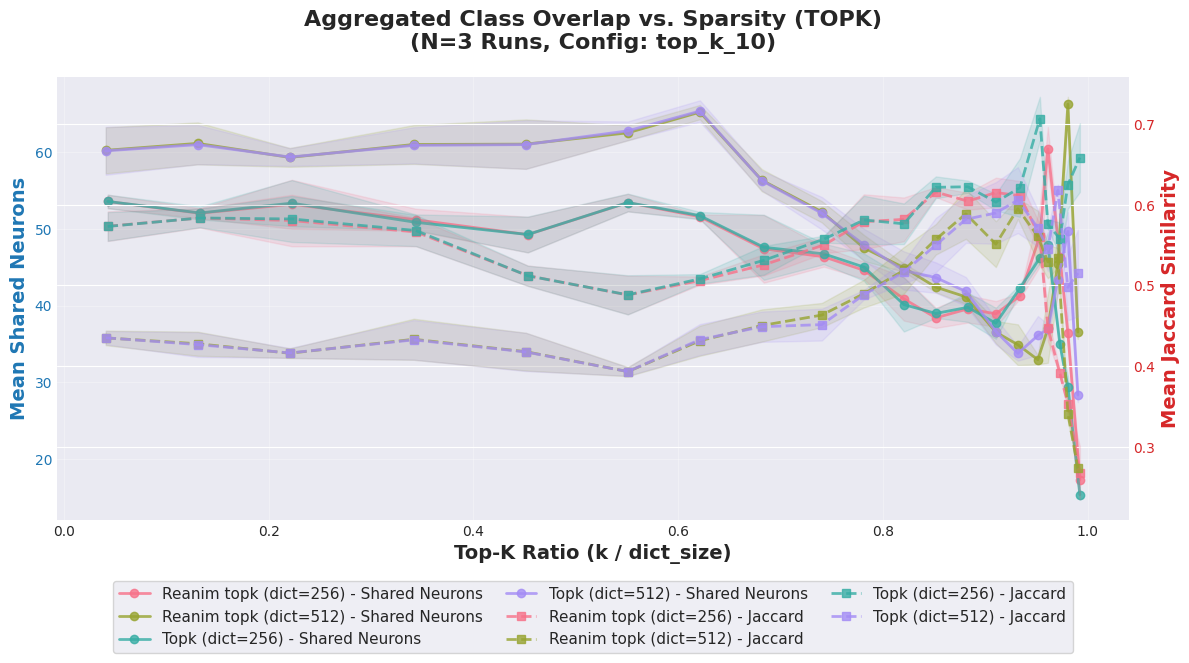

In [3]:
CONFIG_TO_USE = 'top_k_10'

paths_to_runs = [
    # Example L1 SAEs
    '../logs/cifar10expt5/Seed1/topk_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed2/topk_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed3/topk_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'cifar10_topk_sae_topk10'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)


Aggregating data from 3 runs...
✓ Plot saved to cifar10_topk_sae_topk20_topk.png


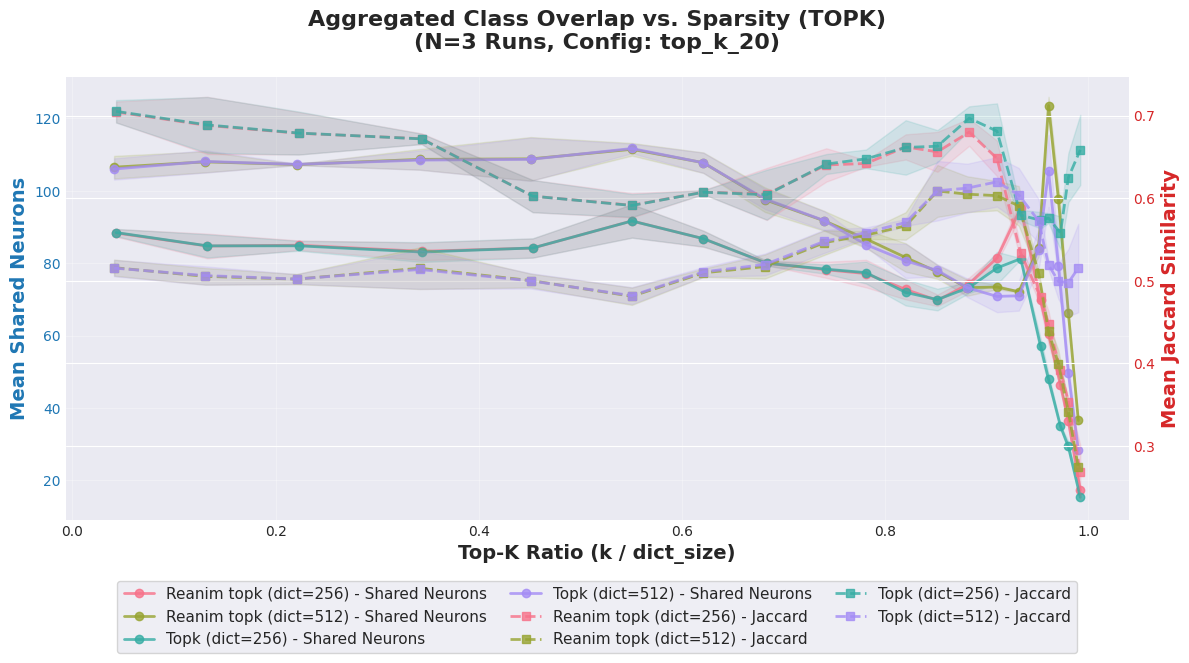

In [4]:
CONFIG_TO_USE = 'top_k_20'

paths_to_runs = [
    # Example L1 SAEs
    '../logs/cifar10expt5/Seed1/topk_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed2/topk_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed3/topk_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'cifar10_topk_sae_topk20'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to cifar10_topk_sae_percentile90_topk.png


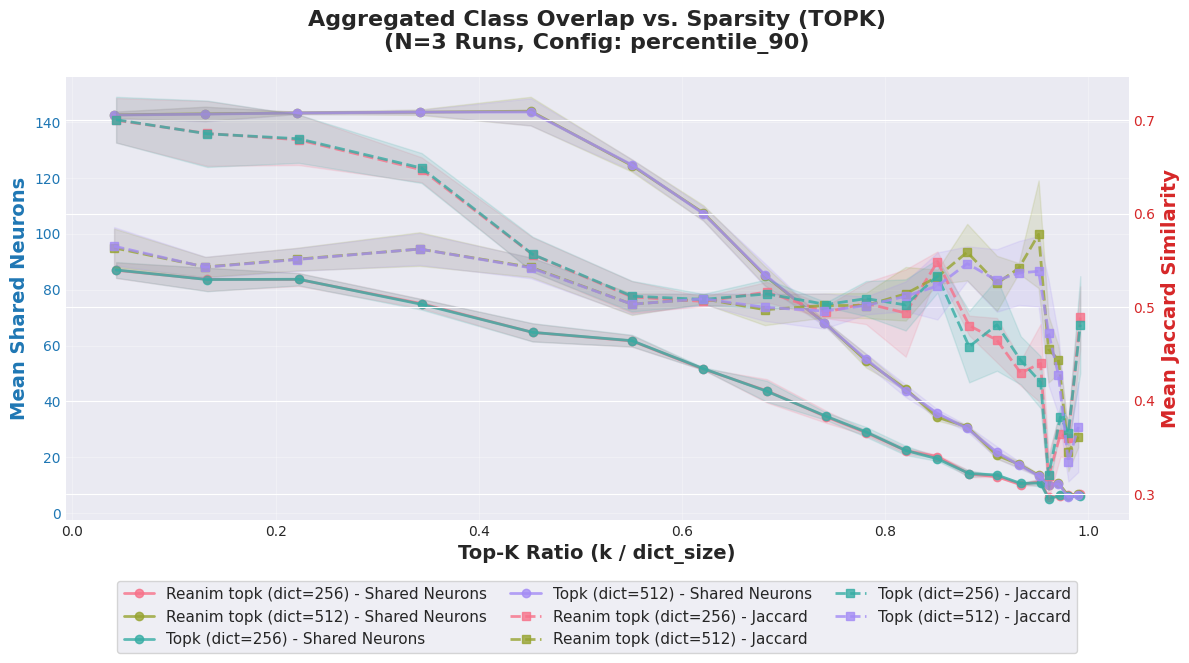

In [5]:
CONFIG_TO_USE = 'percentile_90'

paths_to_runs = [
    # Example L1 SAEs
    '../logs/cifar10expt5/Seed1/topk_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed2/topk_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed3/topk_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'cifar10_topk_sae_percentile90'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to cifar10_topk_sae_std_threshold_topk.png


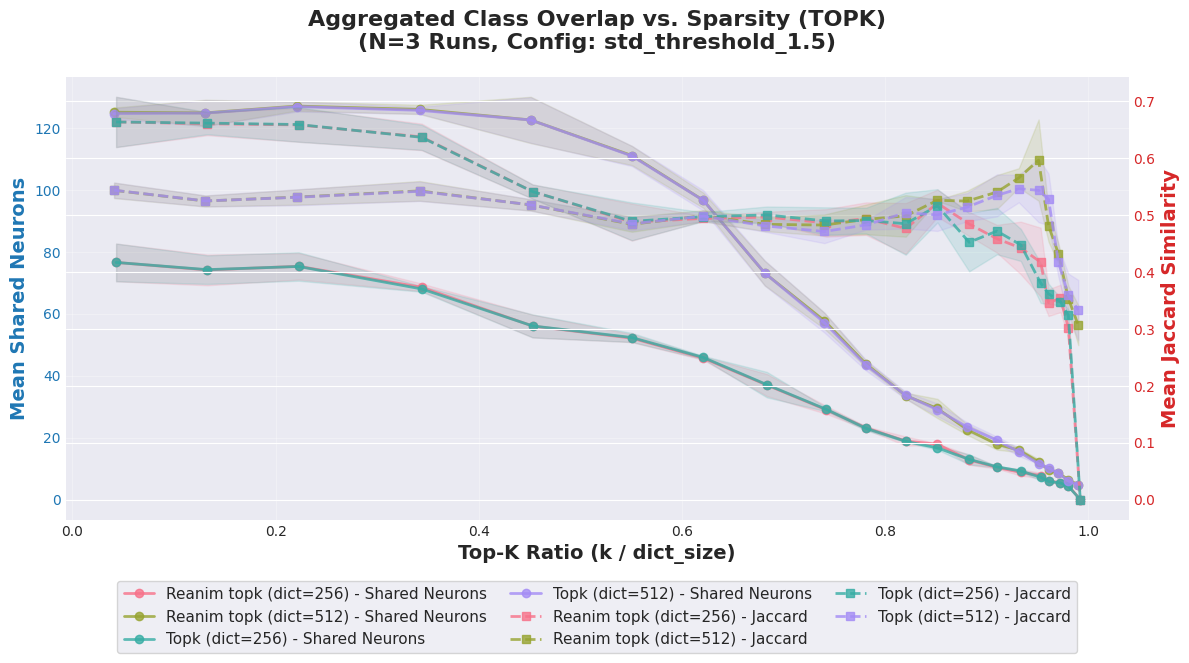

In [19]:
CONFIG_TO_USE = 'std_threshold_1.5'

paths_to_runs = [
    # Example L1 SAEs
    '../logs/cifar10expt5/Seed1/topk_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed2/topk_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed3/topk_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'cifar10_topk_sae_std_threshold'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to cifar10_vanilla_sae_topk10_l1.png


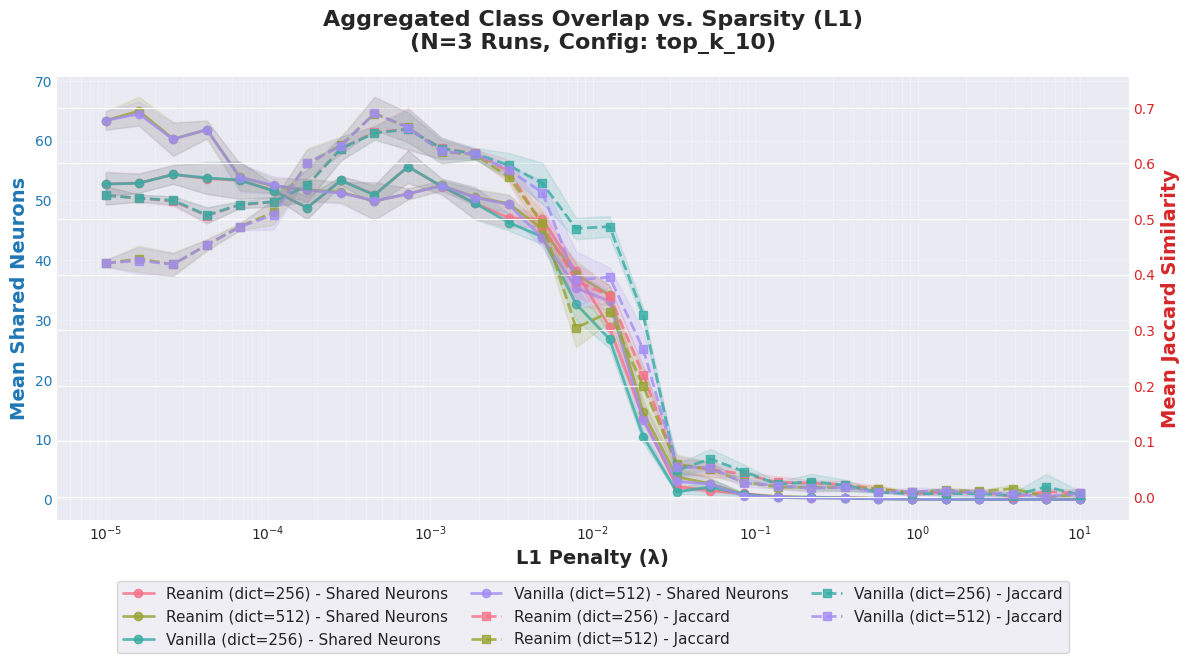

In [7]:
CONFIG_TO_USE = 'top_k_10'

paths_to_runs = [
    # Example L1 SAEs
    '../logs/cifar10expt5/Seed1/vanilla_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed2/vanilla_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed3/vanilla_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'cifar10_vanilla_sae_topk10'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to cifar10_vanilla_sae_topk20_l1.png


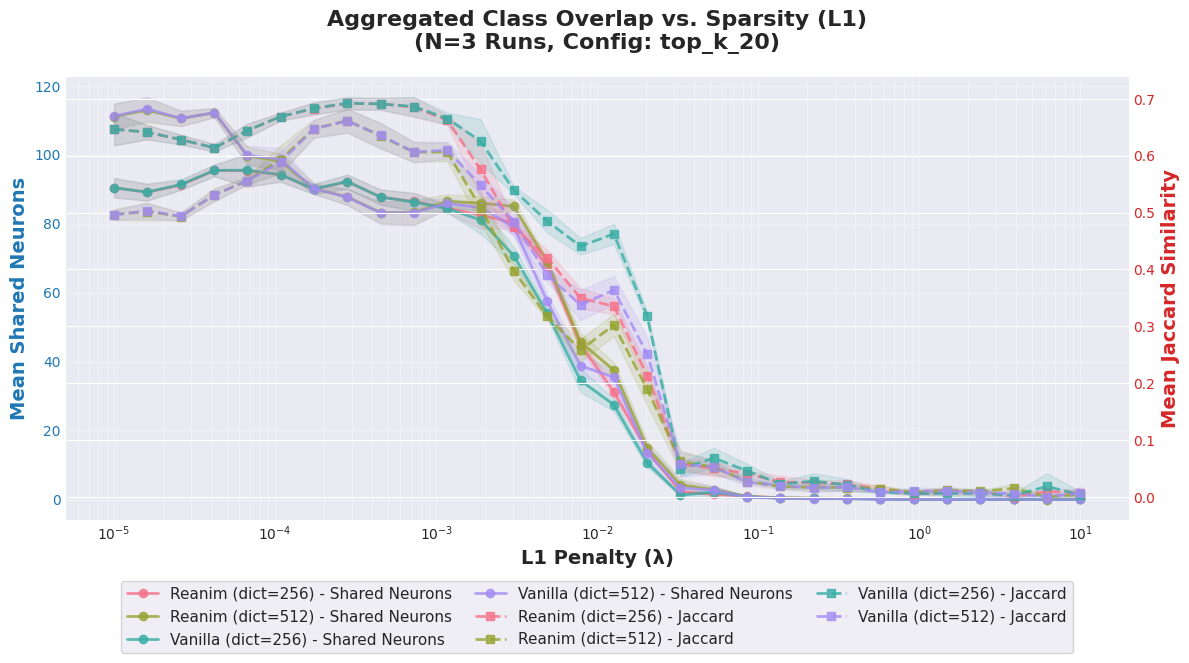

In [8]:
CONFIG_TO_USE = 'top_k_20'

paths_to_runs = [
    # Example L1 SAEs
    '../logs/cifar10expt5/Seed1/vanilla_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed2/vanilla_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed3/vanilla_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'cifar10_vanilla_sae_topk20'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to cifar10_vanilla_sae_percentile_90_l1.png


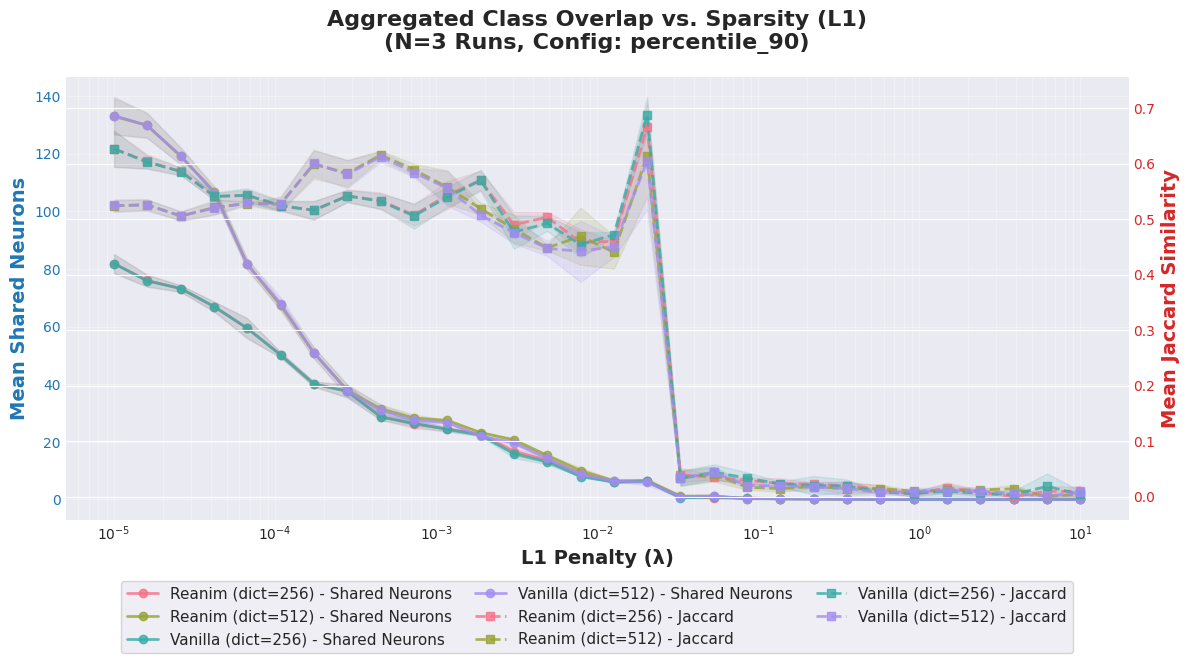

In [9]:
CONFIG_TO_USE = 'percentile_90'
# CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
# CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    '../logs/cifar10expt5/Seed1/vanilla_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed2/vanilla_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed3/vanilla_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'cifar10_vanilla_sae_percentile_90'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

In [ ]:
# CONFIG_TO_USE = 'percentile_90'
CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
# CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/cifar10expt5/Seed1/vanilla_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed2/vanilla_sae/new_concept_path_results.pkl',
    '../logs/cifar10expt5/Seed3/vanilla_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'cifar10_vanilla_sae_std_threshold'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...


# MNIST

Aggregating data from 3 runs...
✓ Plot saved to mnist_topk_sae_topk_10_topk.png


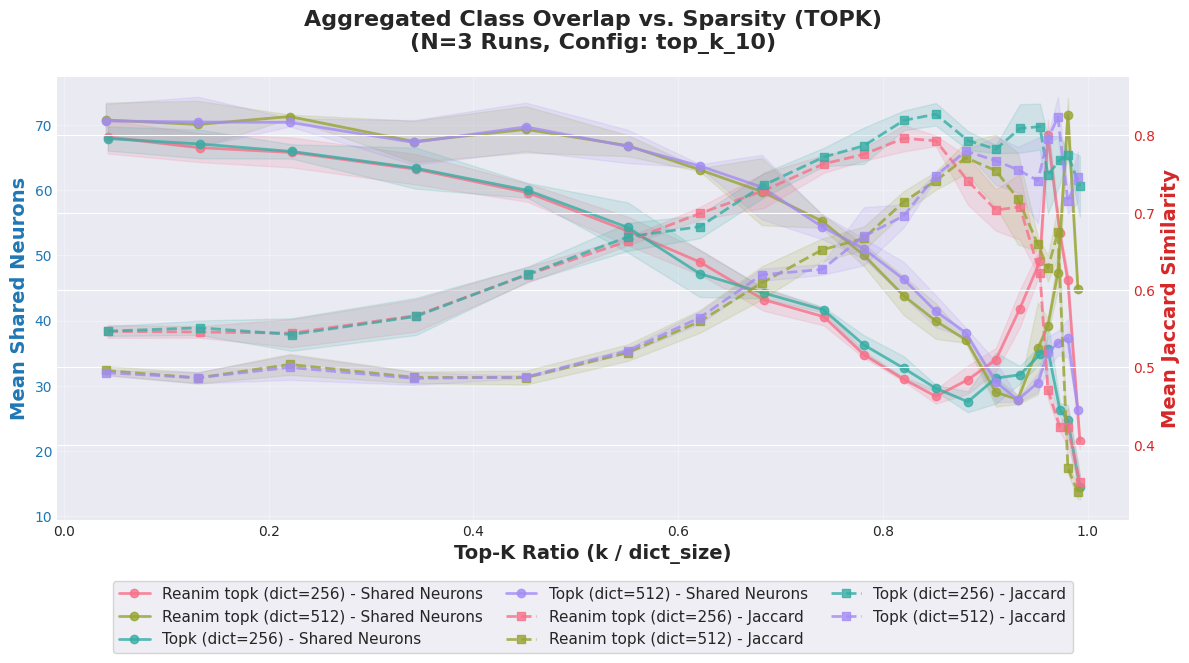

In [11]:
# CONFIG_TO_USE = 'percentile_90'
# CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/mnist_activation/Seed1/topk_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed2/topk_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed3/topk_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'mnist_topk_sae_topk_10'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to mnist_topk_sae_topk_20_topk.png


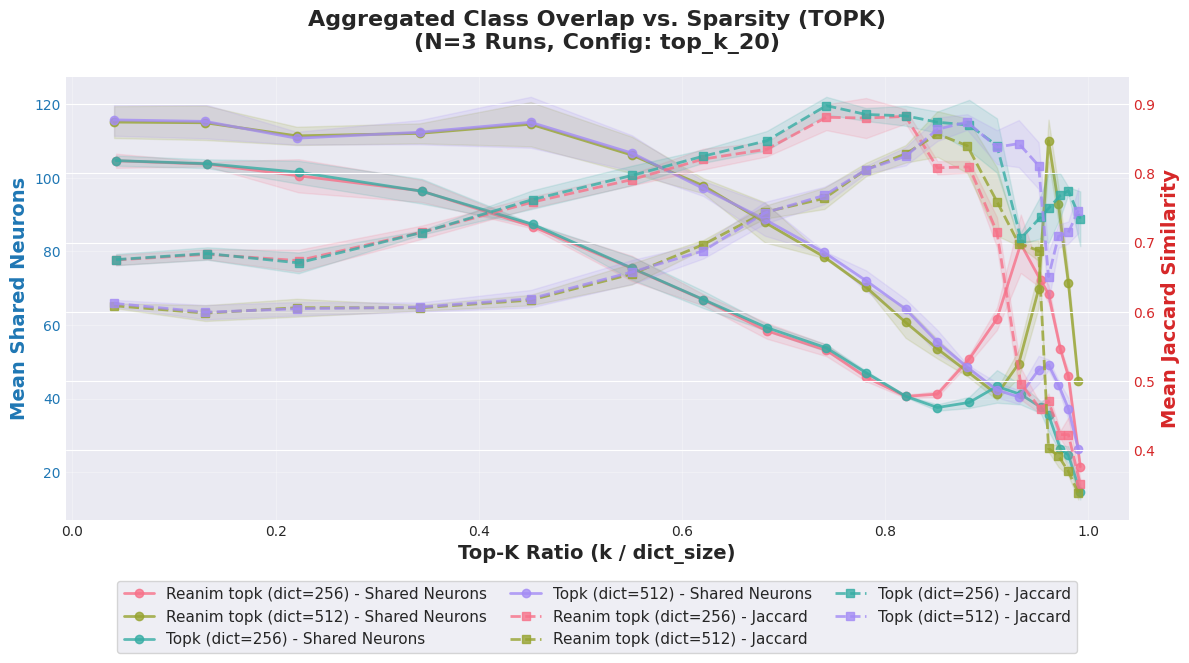

In [12]:
# CONFIG_TO_USE = 'percentile_90'
# CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
CONFIG_TO_USE = 'top_k_20'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/mnist_activation/Seed1/topk_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed2/topk_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed3/topk_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'mnist_topk_sae_topk_20'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to mnist_topk_sae_percentile_90_topk.png


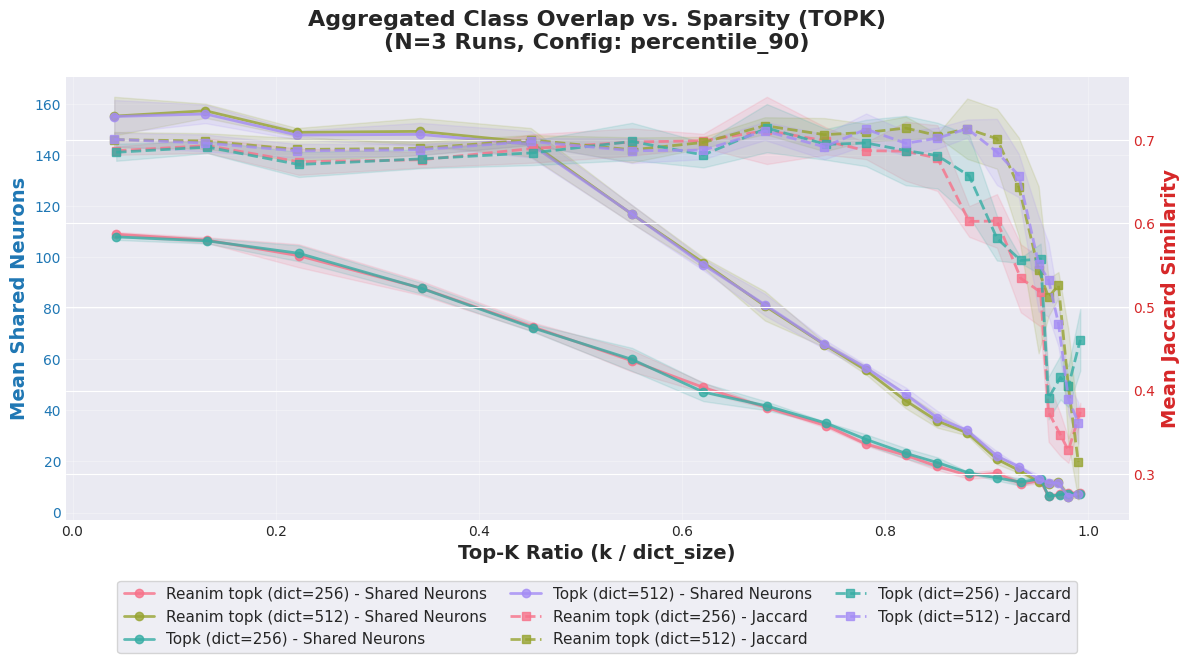

In [13]:
CONFIG_TO_USE = 'percentile_90'
# CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
# CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/mnist_activation/Seed1/topk_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed2/topk_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed3/topk_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'mnist_topk_sae_percentile_90'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

In [ ]:
# CONFIG_TO_USE = 'percentile_90'
CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
# CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/mnist_activation/Seed1/topk_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed2/topk_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed3/topk_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'mnist_topk_sae_std_threshold'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to mnist_vanilla_sae_topk_20_l1.png


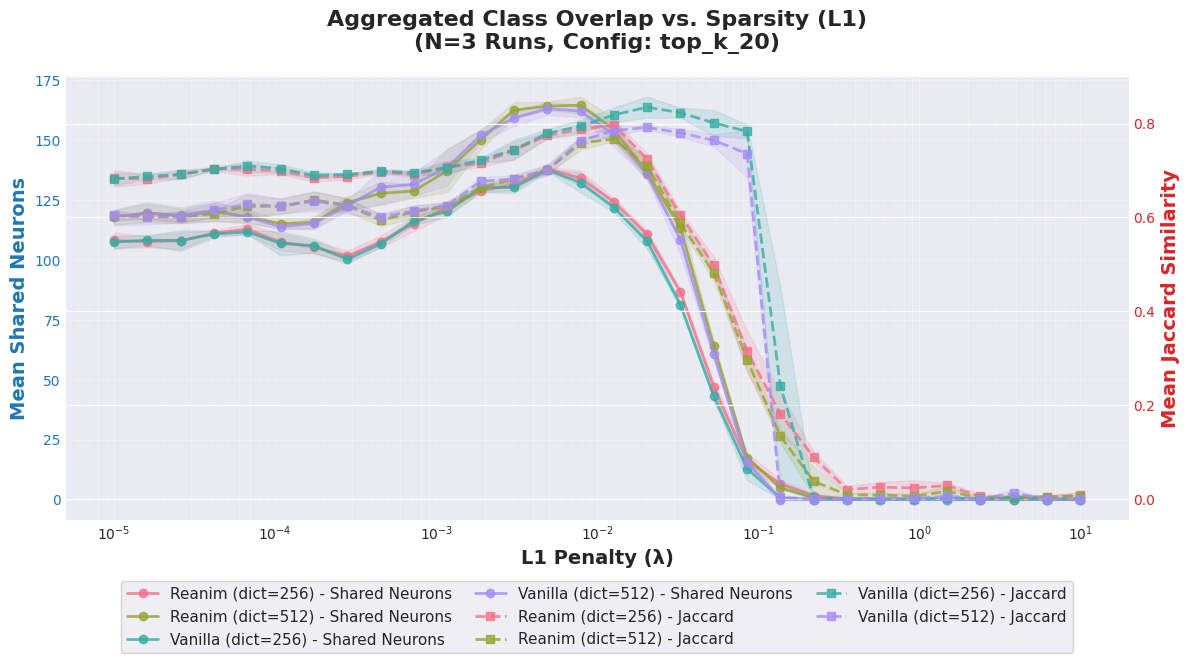

In [15]:
# CONFIG_TO_USE = 'percentile_90'
# CONFIG_TO_USE = 'std_threshold_1.5'
CONFIG_TO_USE = 'top_k_20'
# CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/mnist_activation/Seed1/vanilla_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed2/vanilla_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed3/vanilla_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'mnist_vanilla_sae_topk_20'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to mnist_vanilla_sae_topk_10_l1.png


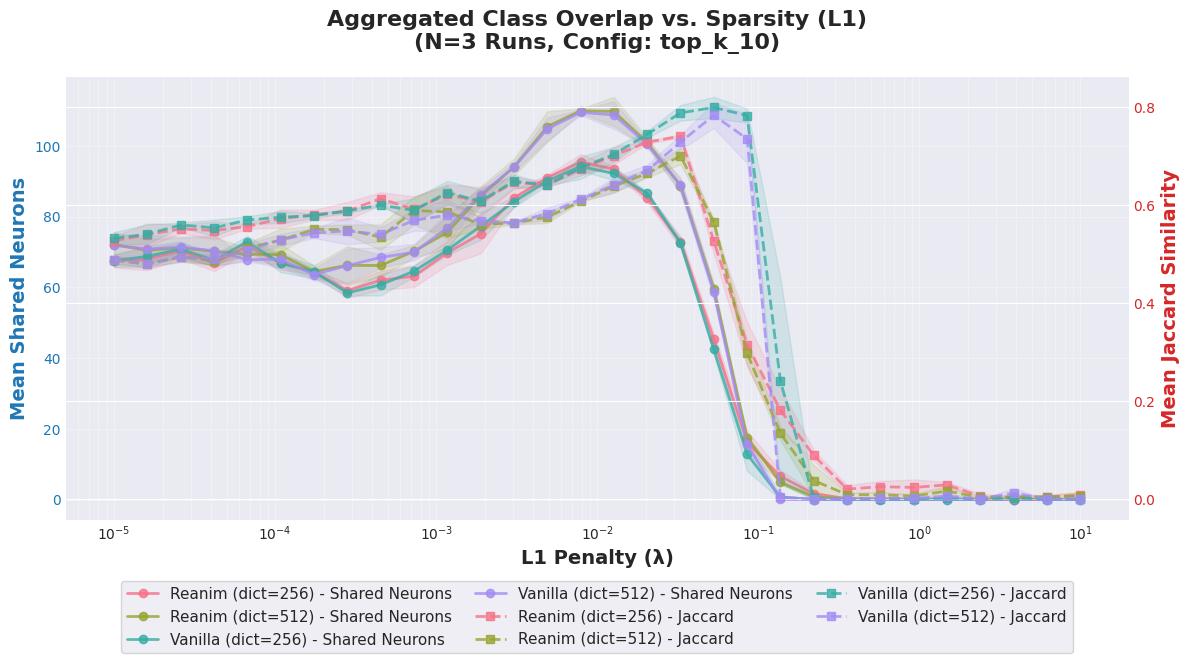

In [16]:
# CONFIG_TO_USE = 'percentile_90'
# CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/mnist_activation/Seed1/vanilla_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed2/vanilla_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed3/vanilla_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'mnist_vanilla_sae_topk_10'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

Aggregating data from 3 runs...
✓ Plot saved to mnist_vanilla_sae_percentile_90_l1.png


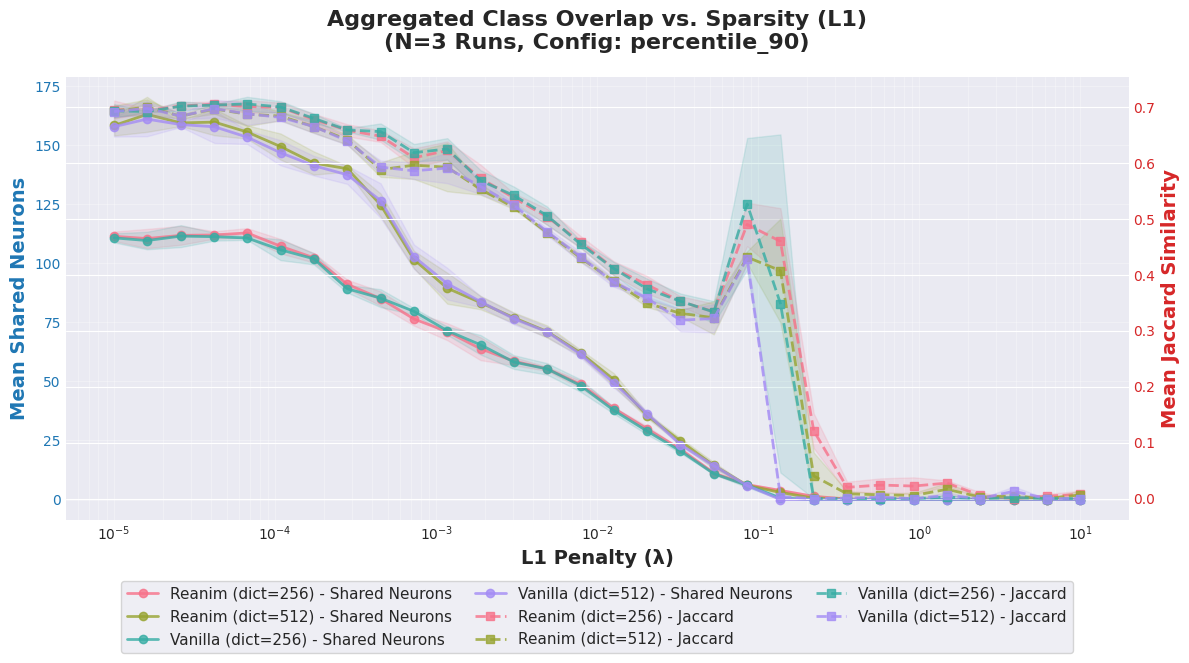

In [17]:
CONFIG_TO_USE = 'percentile_90'
# CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
# CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/mnist_activation/Seed1/vanilla_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed2/vanilla_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed3/vanilla_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'mnist_vanilla_sae_percentile_90'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)

In [ ]:
# CONFIG_TO_USE = 'percentile_90'
CONFIG_TO_USE = 'std_threshold_1.5'
# CONFIG_TO_USE = 'top_k_20'
# CONFIG_TO_USE = 'top_k_10'


paths_to_runs = [
    # Example L1 SAEs
    '../logs/mnist_activation/Seed1/vanilla_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed2/vanilla_sae/new_concept_path_results.pkl',
    '../logs/mnist_activation/Seed3/vanilla_sae/new_concept_path_results.pkl',

]

SAVE_FILE_BASE = 'mnist_vanilla_sae_std_threshold'

print(f"Aggregating data from {len(paths_to_runs)} runs...")

aggregated_data_dict = plot_aggregated_class_overlap(
    concept_path_files=paths_to_runs,
    config_to_use=CONFIG_TO_USE,
    l1_penalty_map=L1_PENALTY_MAP,
    save_path_base=SAVE_FILE_BASE
)